In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
data = pd.read_csv("/content/data.csv")

# Drop ID column if present
if "id" in data.columns:
    data = data.drop("id", axis=1)

# Convert Diagnosis: M -> 1 , B -> 0
data["diagnosis"] = data["diagnosis"].map({"M":1, "B":0})

X = data.drop("diagnosis", axis=1).values
y = data["diagnosis"].values


In [3]:
np.random.seed(42)

indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))

train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [4]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


In [5]:
def euclidean(a,b):
    return np.sqrt(np.sum((a-b)**2))

def manhattan(a,b):
    return np.sum(np.abs(a-b))

def minkowski(a,b,p=3):
    return np.power(np.sum(np.abs(a-b)**p),1/p)

def cosine(a,b):
    return 1 - np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def hamming(a,b):
    return np.mean(a!=b)


In [6]:
class KNN:
    def __init__(self,k,distance):
        self.k = k
        self.distance = distance

    def fit(self,X,y):
        self.X = X
        self.y = y

    def predict_one(self,x):
        distances = []
        for i in range(len(self.X)):
            distances.append(self.distance(x,self.X[i]))

        idx = np.argsort(distances)[:self.k]
        labels = self.y[idx]

        return Counter(labels).most_common(1)[0][0]

    def predict(self,X):
        return np.array([self.predict_one(x) for x in X])


In [7]:
def accuracy(y_true,y_pred):
    return np.mean(y_true==y_pred)


In [8]:
Ks = [3,4,9,20,47]

distances = {
    "Euclidean": euclidean,
    "Manhattan": manhattan,
    "Minkowski": minkowski,
    "Cosine": cosine,
    "Hamming": hamming
}

results = {}

for name,dist in distances.items():
    accs = []
    for k in Ks:
        model = KNN(k,dist)
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        accs.append(accuracy(y_test,preds))
    results[name]=accs

results


{'Euclidean': [np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141)],
 'Manhattan': [np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141)],
 'Minkowski': [np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141)],
 'Cosine': [np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141),
  np.float64(0.5877192982456141)],
 'Hamming': [np.float64(0.7105263157894737),
  np.float64(0.6140350877192983),
  np.float64(0.6403508771929824),
  np.float64(0.6666666666666666),
  np.float64(0.5877192982456141)]}

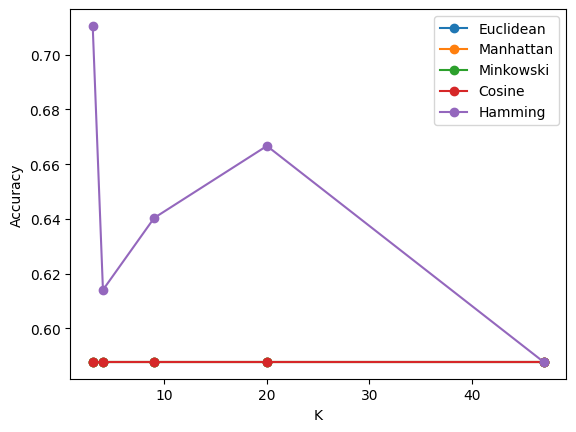

In [9]:
plt.figure()

for name,acc in results.items():
    plt.plot(Ks,acc,marker='o',label=name)

plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [10]:
best_acc = 0

for name,accs in results.items():
    for i,a in enumerate(accs):
        if a > best_acc:
            best_acc = a
            best_k = Ks[i]
            best_dist = name

best_k, best_dist, best_acc


(3, 'Hamming', np.float64(0.7105263157894737))

In [11]:
best_model = KNN(best_k, distances[best_dist])
best_model.fit(X_train,y_train)

preds = best_model.predict(X_test)

TP = np.sum((preds==1)&(y_test==1))
TN = np.sum((preds==0)&(y_test==0))
FP = np.sum((preds==1)&(y_test==0))
FN = np.sum((preds==0)&(y_test==1))

confusion = np.array([[TN,FP],[FN,TP]])

precision = TP/(TP+FP)
recall = TP/(TP+FN)

confusion, precision, recall


(array([[61,  6],
        [27, 20]]),
 np.float64(0.7692307692307693),
 np.float64(0.425531914893617))

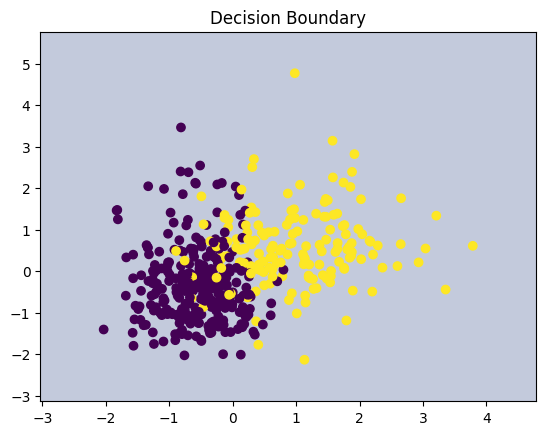

In [12]:
X2 = X_train[:,0:2]
y2 = y_train

model2 = KNN(best_k, distances[best_dist])
model2.fit(X2,y2)

x_min,x_max = X2[:,0].min()-1, X2[:,0].max()+1
y_min,y_max = X2[:,1].min()-1, X2[:,1].max()+1

xx,yy = np.meshgrid(np.linspace(x_min,x_max,100),
                    np.linspace(y_min,y_max,100))

grid = np.c_[xx.ravel(),yy.ravel()]
Z = model2.predict(grid)
Z = Z.reshape(xx.shape)

plt.contourf(xx,yy,Z,alpha=0.3)
plt.scatter(X2[:,0],X2[:,1],c=y2)
plt.title("Decision Boundary")
plt.show()
